# Learning outcomes
- IOU

In [1]:
import sys
assert sys.version_info >= (3, 7)

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from util_func import *

if not cv.useOptimized():
    cv.setUseOptimized(True)
    
cv.useOptimized()

True

## IOU
IOU = |A intercept B| / |A union B|

In [2]:
def computeIOU(boxA,boxB):
    """boxA and boxB are xyxy formats"""
    
    x_start = max(boxA[0],boxB[0])
    y_start = max(boxA[1],boxB[1])
    x_end = min(boxA[2],boxB[2])
    y_end = min(boxA[3],boxB[3])
    
    interArea = max(0, x_end - x_start + 1) * max(0,y_end - y_start + 1)
    
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

In [3]:
img = cv.imread("images/lena.jfif")

In [27]:
boxes = cv.selectROIs("bounding box", img, showCrosshair = False)

cv.waitKey(0)
cv.destroyAllWindows()

In [28]:
boxes

array([[ 62,  98,  95,  83],
       [ 62,  98,  95,  83],
       [114,  61,  88,  90],
       [114,  61,  88,  90]])

In [23]:
def convert_xywh_to_xyxy(box):
    return [box[0],box[1],box[0] + box[2], box[1], box[3]]

In [29]:
gt = convert_xywh_to_xyxy(boxes[0])
pred = convert_xywh_to_xyxy(boxes[1])

img_copy = img.copy()
cv.rectangle(img_copy,(gt[0],gt[1]),(gt[2],gt[3]),(0,0,255),2)
cv.rectangle(img_copy,(pred[0],pred[1]),(pred[2],pred[3]),(255,0,0),2)
cv.putText(img_copy,f"IOU:{computeIOU(gt,pred):.3f}",(10,25),
            cv.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),1)

show_img("IOU",img_copy)

# Edge detection
Sobel x operator kernel formulation:

[-1,0,1 
-2,0,2
-1,0,1]

In [31]:
img = cv.imread("images/wood_planck.jfif",0)

th = cv.threshold(img,200,255,cv.THRESH_BINARY_INV)[1]

show_img("binary",th)

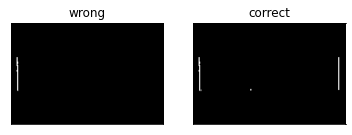

In [32]:
# sobel operators (WRONG)
sobelx_8u = cv.Sobel(th,cv.CV_8U, 1, 0)

# (CORRECT)
sobelx_32f = cv.Sobel(th,cv.CV_32F,1,0)
sobelx = cv.convertScaleAbs(sobelx_32f) # absolute and convert to uint8

plt.subplot(121), plt_img(sobelx_8u,"wrong")
plt.subplot(122), plt_img(sobelx,"correct")
plt.show()

### combine x and y edges

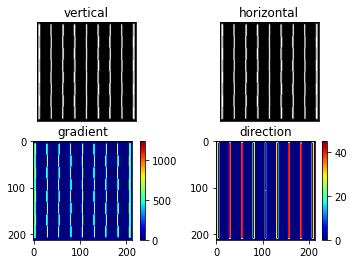

In [33]:
img = cv.imread("images/chessboard.png",0)

# sobel x and y
sobelx_32f = cv.Sobel(img,cv.CV_32F,1,0)
sobelx = cv.convertScaleAbs(sobelx_32f)
sobely_32f = cv.Sobel(img,cv.CV_32F,1,0)
sobely = cv.convertScaleAbs(sobely_32f)

# gradient and direction
gradient = cv.magnitude(sobelx_32f,sobely_32f)
direction = cv.phase(sobelx_32f,sobely_32f,angleInDegrees=True) % 180

plt.subplot(221), plt_img(sobelx,"vertical")
plt.subplot(222), plt_img(sobely,"horizontal")
plt.subplot(223), plt.imshow(gradient,cmap = "jet"), plt.title("gradient")
plt.colorbar()
plt.subplot(224), plt.imshow(direction,cmap = "jet"), plt.title("direction")
plt.colorbar()
plt.show()

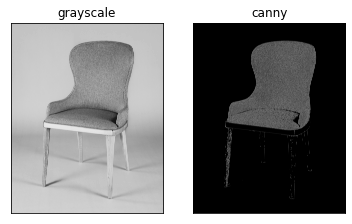

In [34]:
img = cv.imread("images/chair.jpg",0)

edge = cv.Canny(img,100,300)

plt.subplot(121), plt_img(img,"grayscale")
plt.subplot(122), plt_img(edge, "canny")
plt.show()

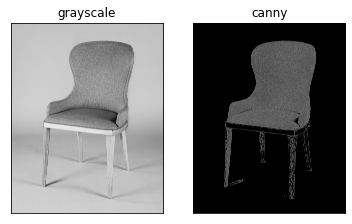

In [35]:
img = cv.imread("images/chair.jpg",0)

edge = cv.Canny(img,30,150)

plt.subplot(121), plt_img(img,"grayscale")
plt.subplot(122), plt_img(edge, "canny")
plt.show()

# Exercise

In [4]:
img = cv.imread("images/chair.jpg")
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

ratio = 2.5
trackbar_name = "Th1"
wn = "canny"
ksize = 3

def cannyThreshold(val):
    """Trackbar callback function"""
    edge = cv.Canny(gray,val,ratio*val,apertureSize = ksize)
    mask = edge != 0
    res = img * (mask[:,:,None].astype(np.uint8))
    cv.imshow(wn,res)
    
cv.namedWindow(wn)
cv.createTrackbar(trackbar_name, wn,10,100,cannyThreshold)

cv.waitKey(0)
cv.destroyAllWindows()

In [7]:
def auto_canny(img,method,sigma = 0.33):
    """Args:
    img:grayscale image
    method: median, otsu, triangle
    sigma: 0.33 (default)"""
    
    if method == "median":
        Th = np.median(img)
        
    elif method == "otsu":
        Th = cv.threshold(img,0,255,cv.THRESH_OTSU)[0]
        
    elif method == "triangle":
        Th = cv.threshold(img,0,255,cv.THRESH_TRIANGLE)[0]

    else:
        raise Exception("Method specified unavailable")
        
    lowTh = (1-sigma) * Th
    highTh = (1+sigma) * Th
    
    return cv.Canny(img,lowTh,highTh)

## Contour detection

In [41]:
rect = np.zeros((256,256),dtype = np.uint8)

cv.rectangle(rect,(25,25),(231,231),255,-1)

show_img("rect",rect)

In [43]:
contours, _ = cv.findContours(rect,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

len(contours)

1

In [44]:
contours

(array([[[ 25,  25]],
 
        [[ 25, 231]],
 
        [[231, 231]],
 
        [[231,  25]]], dtype=int32),)

In [47]:
img_bgr = cv.imread("images/monitor.jfif")
img = cv.imread("images/monitor.jfif",0)

#threshold
th = cv.threshold(img,200,255,cv.THRESH_BINARY_INV)[1]

show_img("threshold",th)

contours, _ = cv.findContours(th,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

In [46]:
len(contours)

12

In [48]:
cv.drawContours(img_bgr,contours,-1,(0,255,0),1)


show_img("contours",img_bgr)

In [49]:
contours, _ = cv.findContours(th,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
img_bgr_copy = img_bgr.copy()
cv.drawContours(img_bgr,contours,-1,(0,255,0),1)

show_img("contours",img_bgr_copy)

In [50]:
contours, _ = cv.findContours(th,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

In [51]:
# contours with maximum number of points
length = [len(c) for c in contours]
contour_largest = contours[np.argmax(length)]

img_bgr_copy = img_bgr.copy()
cv.drawContours(img_bgr_copy,[contour_largest],-1,(0,255,0),1)

show_img("contours",img_bgr_copy)

In [52]:
cnt = contour_largest

## Contour features

In [53]:
M = cv.moments(cnt)
print(M)

{'m00': 37113.5, 'm10': 3913689.5, 'm01': 3849569.1666666665, 'm20': 529272493.25, 'm11': 402572898.125, 'm02': 519454930.25, 'm30': 80631725758.65001, 'm21': 53484537787.45, 'm12': 53828827220.55, 'm03': 80175930424.35, 'mu20': 116566456.29821026, 'mu11': -3371527.140929699, 'mu02': 120161337.11136603, 'mu30': 234618732.78678894, 'mu21': -702775455.4171028, 'mu12': -249269762.75935364, 'mu03': 1368584318.4292145, 'nu20': 0.08462716040157804, 'nu11': -0.0024477261916909816, 'nu02': 0.08723704119285126, 'nu30': 0.0008841641534443626, 'nu21': -0.002648419664618219, 'nu12': -0.0009393767758931957, 'nu03': 0.005157530180767104}


In [54]:
# centroid (center of mass)
cx = int(M["m10"]/M["m00"])
cy = int(M["m01"]/M["m00"])

print(f"the centroid of monitor: {(cx,cy)}")


the centroid of monitor: (105, 103)


In [55]:
# area and perimeter
area = cv.contourArea(cnt)
peri = cv.arcLength(cnt,True)

print(f"The area of monitor:{area}")
print(f"The perimeter of monitor:{peri:.3f}")

The area of monitor:37113.5
The perimeter of monitor:1056.777


In [5]:
img = cv.imread("images/remote-controller.webp")

In [8]:
# resize -> grayscale -> bilateral filter -> edge detection -> find contour 
# contour features
factor = 300 / img.shape[1]
img = cv.resize(img,None,fx = factor,fy=factor)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
blur = cv.bilateralFilter(gray,7,19,13)
edge = auto_canny(blur,method="triangle")

# find contour
contours, _ = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# area
contours = sorted(contours,key=cv.contourArea,reverse=True)[:5]
screen = None
img_copy = img.copy()

for c in contours:
    peri = cv.arcLength(c,True)
    approx = cv.approxPolyDP(c,0.1*peri,True)
    
    if len(approx) == 4:
        screen = c
        break
        
cv.drawContours(img_copy,[screen],-1,(0,255,0),2)
show_img("screen", img_copy)

# Circularity
 Circularity = (4*pi*Area)/Perimeter^2

## Demo on red object detector

In [13]:
redLow1 = (0,90,40)
redHigh1 = (10,255,210)

redLow2 = (170,90,40)
redHigh2 = (179,255,210)

cap = cv.VideoCapture(0)

if not cap.isOpened():
    sys.exit("No webcame detected")

# factor
fixed_width = min_area = 500
factor = fixed_width / cap.get(3) #frame width
kernel = np.ones((3,3),dtype=np.uint8)

while(1):
    ret,frame = cap.read()
    
    if not ret:
        print("No frame received")
        break
    
    # resize, blur, change to hsv, inRange, mask integration, morphological
    # operation, find contour, bounding box
    resized = cv.resize(frame, None, fx = factor,fy=factor)
    blur = cv.GaussianBlur(resized,(5,5),0)
    img_hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
    
    mask1 = cv.inRange(img_hsv, redLow1,redHigh1)
    mask2 = cv.inRange(img_hsv, redLow2,redHigh2)
    mask = cv.add(mask1,mask2)
    
    # supress noise
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN,kernel,iterations=2)
    
    # find contours
    contours, _ = cv.findContours(mask,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    
    bbs = []
    centroids = []
    for c in contours:
        area = cv.contourArea(c)
        if area > min_area:
            bb = cv.boundingRect(c)
            M = cv.moments(c)
            cx = int(M["m10"]/M["m00"])
            cy = int(M["m01"]/M["m00"])
            centroids.append((cx,cy))
            bbs.append(bb)
            
    for bb, centroid in zip(bbs,centroids):
        x,y,w,h = bb
        cv.rectangle(resized,(x,y),(x+w,y+h),(0,255,0),2)
        cv.circle(resized,centroid,2,(255,0,0),-1)
        
    cv.imshow("red object",resized)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()
cap.release()

# Weekly Activity
## Exercise 1

In [27]:
# Read the image
image = cv.imread('images/pineapple.jfif', 0)

ksize = 3

# Apply Sobel edge detector
sobelx_32f = cv.Sobel(image,cv.CV_32F,1,0)
sobely_32f = cv.Sobel(image,cv.CV_32F,1,0)
sobel = sobelx_32f + sobely_32f

# Apply Laplacian edge detector
laplacian = cv.Laplacian(image, cv.CV_32F, ksize=ksize)
laplacian = cv.convertScaleAbs(laplacian)

# Define Prewitt kernels
kernel_x = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernel_y = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])

# Apply Prewitt edge detector
prewitt_x = cv.filter2D(image, -1, kernel_x)
prewitt_y = cv.filter2D(image, -1, kernel_y)
prewitt = prewitt_x + prewitt_y

# Define Scharr kernels
skernel_x = np.array([[3,0,-3],[10,0,-10],[3,0,-3]])
skernel_y = np.array([[3,10,3],[0,0,0],[-3,-10,-3]])

# Apply Scharr edge detector
scharr_x = cv.filter2D(image, -1, skernel_x)
scharr_y = cv.filter2D(image, -1, skernel_y)
scharr = scharr_x + scharr_y

# Apply Canny edge detector
canny = cv.Canny(image, threshold1=100, threshold2=300, apertureSize=ksize)

# Display the edge detection results
cv.imshow('Original Image', image)

# highlights edges with higher contrast. The edges are thick, and both horizontal and vertical edges are captured.
cv.imshow('Sobel Edges', sobel)

# edges as positive and negative intensity changes. The edges are generally thin and appear as dark lines on a white background.
cv.imshow('Laplacian Edges', laplacian)

# highlights edges in both horizontal and vertical directions, similar to Sobel.
cv.imshow('Prewitt Edges', prewitt)

# enhances edges in a manner similar to Sobel but can capture finer details.
cv.imshow('Scharr Edges', scharr)

# well-defined edges with thin lines. It also marks the detected edges with double edges to indicate stronger responses.
cv.imshow('Canny Edges', canny)

cv.waitKey(0)
cv.destroyAllWindows()

## Exercise 2

In [28]:
# Read the image
image = cv.imread('images/electronic.jfif')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Threshold the image to create a binary mask of white regions
_, thresh = cv.threshold(gray, 200, 255, cv.THRESH_BINARY)

# Find contours in the binary mask
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Loop through the detected contours and draw bounding boxes
for contour in contours:
    area = cv.contourArea(contour)
    if area > 500:  # Adjust this threshold based on your image
        x, y, w, h = cv.boundingRect(contour)
        cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with bounding boxes
cv.imshow('Detected White Objects', image)
cv.waitKey(0)
cv.destroyAllWindows()

## Exercise 3

In [29]:
# Read the image
image = cv.imread('images/clock.jpg')

# Convert the image to grayscale
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv.GaussianBlur(gray, (5, 5), 0)

# Apply Canny edge detection
edges = cv.Canny(blurred, threshold1=30, threshold2=70)

# Find contours in the edge-detected image
contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Filter contours based on area and circularity
min_area = 1000  # Minimum area threshold
max_circularity = 0.5  # Maximum circularity (1.0 for perfect circle)
filtered_contours = []
for contour in contours:
    area = cv.contourArea(contour)
    perimeter = cv.arcLength(contour, True)
    if perimeter != 0:
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if area > min_area  and circularity > max_circularity:
            filtered_contours.append(contour)
                  
# Draw bounding circles around filtered contours
for contour in filtered_contours:
    (x, y), radius = cv.minEnclosingCircle(contour)
    center = (int(x), int(y))
    radius = int(radius)
    cv.circle(image, center, radius, (0, 255, 0), 2)

# Display the image with bounding circles
cv.imshow('Clock Circular Bounding Boxes', image)
cv.waitKey(0)
cv.destroyAllWindows()